In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger(__name__)
from dedalus import public as de

In [2]:
nz = 256
z_basis = de.Chebyshev('z', nz, interval=[0, 1], dealias=3/2)
domain = de.Domain([z_basis], grid_dtype=np.float64)
problem = de.IVP(domain, variables=['T', 'Tz'])

z = domain.grid(0)
source = domain.new_field()
source['g'] = np.sin(np.pi*z)
problem.parameters['source'] = source

problem.add_equation("Tz - dz(T) = 0")
problem.add_equation("dt(T) - dz(Tz) = source")
problem.add_bc("left(T) = 0")
problem.add_bc("right(T) = 0")

DEBUG:domain:Global coeff shape: [256]
DEBUG:distributor:Mesh: []
DEBUG:problems:Parsing Eqn 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: Tz - dz(T)
DEBUG:problems:  RHS string form: 0
DEBUG:problems:  LHS object form: Tz + (-1*dz(T))
DEBUG:problems:  RHS object form: 0
DEBUG:problems:  M linear form: 0
DEBUG:problems:  L linear form: Tz + (-1*dz(T))
DEBUG:problems:Parsing Eqn 1
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: dt(T) - dz(Tz)
DEBUG:problems:  RHS string form: source
DEBUG:problems:  LHS object form: dt(T) + (-1*dz(Tz))
DEBUG:problems:  RHS object form: source
DEBUG:problems:  M linear form: T
DEBUG:problems:  L linear form: -1*dz(Tz)
DEBUG:problems:Parsing BC 0
DEBUG:problems:  Condition: True
DEBUG:problems:  LHS string form: left(T)
DEBUG:problems:  RHS string form: 0
DEBUG:problems:  LHS object form: interp(T,'z',left)
DEBUG:problems:  RHS object form: 0
DEBUG:problems:  M linear form: 0
DEBUG:problems:  L linear form: interp

In [3]:
delta_t = 0.1
ts = de.timesteppers.RK443
cfl_safety_factor = 0.2*4

# Build solver
solver = problem.build_solver(ts)

DEBUG:solvers:Beginning IVP instantiation
INFO:pencil:Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s


2015-06-12 13:44:46,183 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.0e+01/s


DEBUG:solvers:Finished IVP instantiation


In [4]:
T = solver.state['T']
solver.stop_sim_time = 1
solver.stop_iteration= np.inf
solver.stop_wall_time = 120

DEBUG:basis:Building FFTW DCT plan for (dtype, gshape, axis) = (float64, (256,), 0)
INFO:solvers:Simulation stop time reached.


2015-06-12 13:44:47,468 solvers 0/1 INFO :: Simulation stop time reached.


/usr/local/lib/python3.4/site-packages/matplotlib/axes.py:4749: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


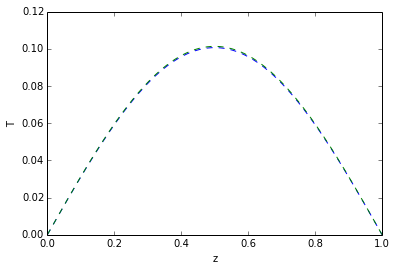

In [5]:
plot_cadence = 5
counter_step = 5
time_counter = counter_step
report = False
while solver.ok:
    solver.step(delta_t)
    if (solver.iteration % plot_cadence == 0):
        t_index = "{}".format(time_counter)
        
        if (solver.iteration % (counter_step*plot_cadence) == 0):
            print(solver.iteration, counter_step*plot_cadence)
            plt.plot(z, T['g'], label=r"$\mathrm{t}_{"+t_index+"}$")
            time_counter += counter_step
        else:
            plt.plot(z, T['g'], linestyle='dashed')
    
    if report:
        logger.info("{} : {:8.3e} -- max_T = {}".format(solver.iteration, 
                                                        solver.sim_time, 
                                                        np.max(T['g'])))
plt.legend()
plt.xlabel('z')
plt.ylabel('T')